In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore")

In [20]:
from pandas import Series
data=Series.from_csv('champagne.csv',header=0)
#data=pd.DataFrame(data)
data.head()

Month
1964-01    2815.0
1964-02    2672.0
1964-03    2755.0
1964-04    2721.0
1964-05    2946.0
Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: float64

In [27]:
split_point=len(data)-15
train,validation=data[0:split_point],data[split_point:]
train.to_csv('train_champagne.csv')
validation.to_csv('validation_champagne.csv')

**Data Visualization**

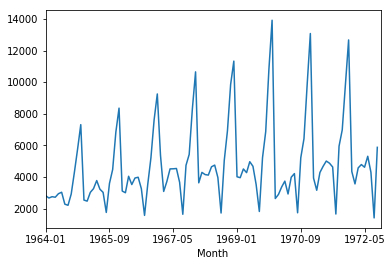

In [28]:
data.plot()
plt.show()

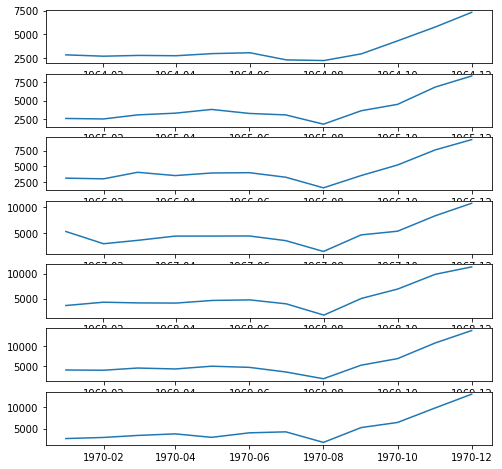

In [94]:
# Check Seasonality
from pandas import TimeGrouper
series=Series.from_csv('train_champagne.csv')
groups=series['1964':'1970'].groupby(TimeGrouper('A'))
years=DataFrame()
i=1
plt.figure(figsize=(8,8))
n_groups=len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

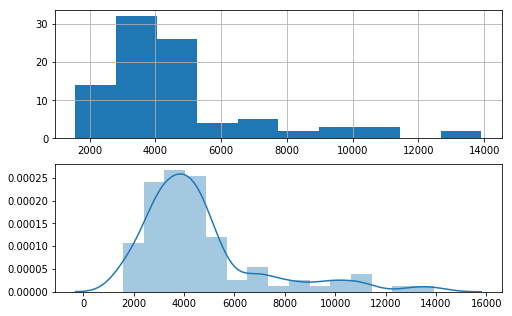

In [78]:
# the seasonality appears yearly and the time series looks non-stationary

import seaborn as sns
plt.figure(figsize=(8,8))
plt.subplot(311)
series.hist()
plt.subplot(312)
sns.distplot(series)
plt.show()

#the distr is not guassian and has a long tail

**ARIMA**

first creating a stationary ts by removing seasonality by yearly differencing

1965-01-01   -274.0
1965-02-01   -197.0
1965-03-01    276.0
1965-04-01    545.0
1965-05-01    830.0
dtype: float64
ADF Statistic: -7.020606
p-value: 0.000000
	1%: -3.517
	5%: -2.899
	10%: -2.587


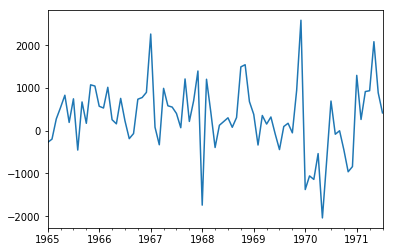

In [100]:
from statsmodels.tsa.stattools import adfuller #unti root test

series=Series.from_csv('train_champagne.csv')
stationary=series.diff(12)
stationary.dropna(axis=0,inplace=True)
print(stationary.head())
stationary.index=series.index[12:]
result=adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationary.plot()
plt.show()

the test statistic is less than 1% p value. The differenced plot doesn't show any seasonality as such and can be used for modeling. Next step os to select lag values of AR,p, and MA,q. This can be done by ACF and PACF functions

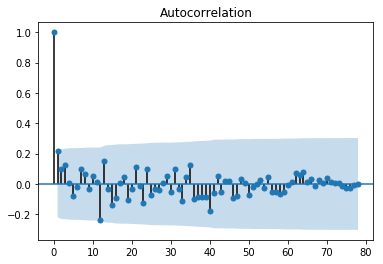

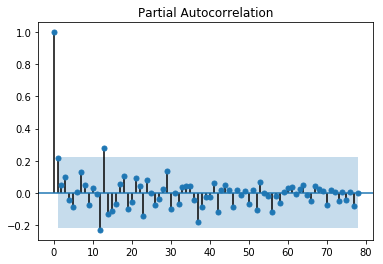

In [110]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(7,7))
plot_acf(stationary)
plot_pacf(stationary)
plt.show()

# the acf plot shows p=1 and the pacf plot shows that q=1. pacf also shows some at 12 and 13 indicating there is still
#some slight seasonality present

ARIMA(1,0,1) is therefore chosen for initiating the model. ARIMA(p,d,q) and d=0 for stationary series we are using for the model. But later we will see that for 101 the model will not converge and will have to choose 111

RMSE: 963.410


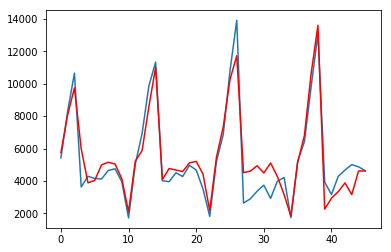

In [142]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# load data
series = Series.from_csv('train_champagne.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

**Grid Search ARIMA parameters**

In [148]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = Series.from_csv('train_champagne.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
evaluate_models(series.values, p_values, d_values, q_values)


Best ARIMANone RMSE=inf
